# Exercise 3: Storage

Your name: Sayeeda Begam Mohamed Ikbal

In previous exercises, you have already worked with the NYTD data set - 
and in the last exercise you even used Parquet at one point (maybe without even noticing).

## Task 1: Compression

Parquet supports different compression schemes; and outside of Parquet, there are dozens of more compression algorithms available, each of them geared towards different use cases with their own strengths and weaknesses.

First, let's start with some priliminary work: understanding the benefits of compression. Not only does compression reduce storage space, but you can also increase the effective throughput when loading data. Why is that? When transferring data, you are usually bound by the channels throughput. This might be the network speed or the throughput limit on hard drives. When reading *compressed* data, less bandwidth is required to read the file because the file is smaller. Great! However, there is one catch: The throughput of the transfer channel is not the only limitation - the decompression throughput is another limit, which is different for each algorithm and dataset. In this exercsise, we'd like to explore this a bit more.

Compression ratios heavily depend on the type of data that is being compressed. Repetitive text, e.g. logs, usually compresses fairly well, while binary data, e.g. images, is oftentimes harder to compress.

Takeaways:
 * Higher compression ratios mean higher effective read throughput
 * Overall read throughput is also limited by the decompression speed of the algorithm



For this task, we will use results from http://quixdb.github.io/squash-benchmark on the "Medical magnetic resonanse image" for the "e-desktop" machine. This is a dataset of images that are well-compressable.

In [11]:
# Load compression benchmark data

import pandas as pd

url = "http://quixdb.github.io/squash-benchmark/data/e-desktop.csv"
df = pd.read_csv(url)

# Do some pre-processing
df = df[df.dataset == "mr"]
df["algorithm"] = df["plugin"] + ":" + df["codec"]
df = df.drop(columns=["plugin", "codec"])

display(df)

,dataset,level,compressed_size,compress_cpu,compress_wall,decompress_cpu,decompress_wall,algorithm
2820,mr,NaN,4393341,0.108975,0.110939,0.072202,0.072238,brieflz:brieflz
2821,mr,1.0,3458228,0.123153,0.123212,0.045740,0.045763,brotli:brotli
2822,mr,2.0,3502025,0.155627,0.155708,0.045233,0.045258,brotli:brotli
2823,mr,3.0,3526515,0.175411,0.175495,0.044723,0.044746,brotli:brotli
2824,mr,4.0,3469270,0.216071,0.216176,0.044143,0.044165,brotli:brotli
...,...,...,...,...,...,...,...,...
3050,mr,2.0,3592407,3.649937,3.651623,0.185818,0.185717,zpaq:zpaq
3051,mr,3.0,2616261,4.127781,4.129764,2.001956,2.002788,zpaq:zpaq
3052,mr,4.0,2212601,9.906205,9.910826,9.743971,9.748473,zpaq:zpaq
3053,mr,5.0,2175988,28.263835,28.277545,28.645518,28.658918,zpaq:zpaq


### Task 1.1

Compute the compression ratios and the effective decompression throughput based on the given data!
For throughput, we use the wall-clock-time.

Use matplotlib to create a with the compression ratio on one axis and the decompression throughput on the other axis.

In [2]:
import math
import matplotlib.pyplot as plt

# Original size of the mr-dataset in bytes. Needed to compute the compression ratio.
orig_size = 9970564

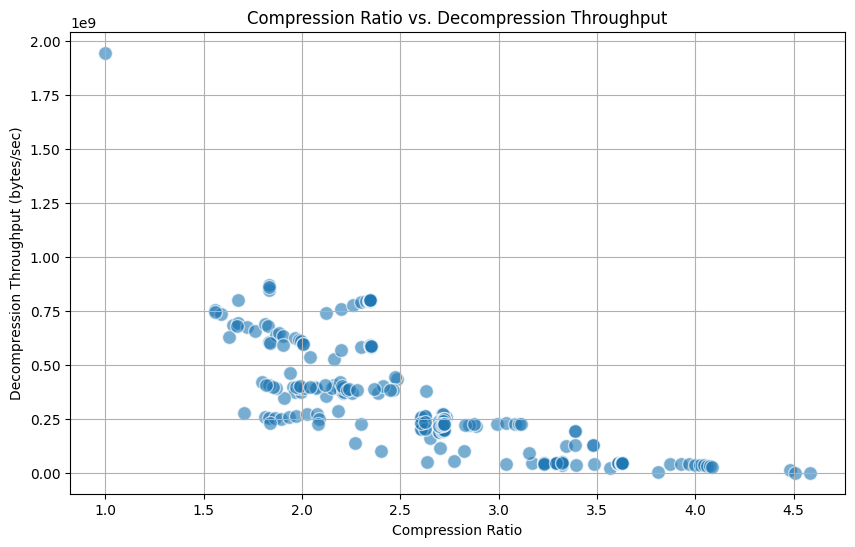

In [5]:
# Solution:
# Estimate runtime: 2s

# <your code here>
df['compression_ratio'] = orig_size / df['compressed_size']
df['decompression_throughput'] = orig_size / df['decompress_wall']

# Now, let's plot the compression ratio vs. decompression throughput
plt.figure(figsize=(10, 6))
plt.scatter(df['compression_ratio'], df['decompression_throughput'], alpha=0.6, edgecolors="w", s=100)
plt.title('Compression Ratio vs. Decompression Throughput')
plt.xlabel('Compression Ratio')
plt.ylabel('Decompression Throughput (bytes/sec)')
plt.grid(True)

# Show the plot
plt.show()

### Task 1.2

Now we would like to figure out which compression algorithm we want to use for this data set (the `mr` data set) to maximize effective throughput.
Compute the effective throughput for each of the compression algorithms on the `mr` data set. Then output the best ones.

In [6]:
# Preliminary constants required for the solution
s3_throughput = 100 * 1000 * 1000 * 1000 / 8 # 100 gbps, in bytes/s, ca 11 GB/s
num_cpus = 72

In [7]:
# Solution
# Estimated runtime: 2s

# <your code here>

# Calculate the effective throughput for each algorithm
df['effective_throughput'] = orig_size / df['decompress_wall']

# Compute the maximum throughput for each algorithm, considering hardware limits
# The throughput is limited by both network throughput and the number of available CPUs
df['limited_throughput'] = df['effective_throughput'].clip(upper=s3_throughput)

# Sorting the dataframe by limited throughput to find the best algorithms
best_algorithms = df[['algorithm', 'limited_throughput']].sort_values(by='limited_throughput', ascending=False)

# Show the top algorithms with the best throughput
best_algorithms.head()

,algorithm,limited_throughput
2842,copy:copy,1.943959e+09
2859,lz4:lz4f,8.673072e+08
2860,lz4:lz4f,8.607186e+08
2858,lz4:lz4f,8.479813e+08
2867,lz4:lz4f,7.987954e+08


### Task 1.3
Parquet does not support every compression algorithm in the list.
See also https://arrow.apache.org/docs/python/generated/pyarrow.parquet.write_table.html
Based on the above observations, what compression algorithm would you use for Parquet and the `mr` data set?

In [ ]:
# Solution (free text, no code required):
# <your code here>
"""Compatibility with Parquet
Parquet, being a columnar storage format widely used in data engineering and analytics, supports a limited set of compression algorithms. These include:

Snappy
Gzip
Brotli
LZ4
Zstd (Zstandard)
The compression algorithms tested in the benchmark, such as Zpaq and Brieflz, are not compatible with Parquet, which narrows the selection to the algorithms supported by the format. This is an important constraint when considering the most suitable compression algorithm for our dataset.

Performance Characteristics
The selection of an appropriate compression algorithm is not solely based on compression ratio; it's a balance between:

Compression Ratio: The ability of the algorithm to reduce the file size.
Decompression Speed: The speed at which the data can be read, which is especially important in environments where the data will be frequently accessed.
CPU and IO Efficiency: The computational resources required during both compression and decompression, which may impact system performance in a multi-user or high-load environment.
Heres a look at the key algorithms supported by Parquet:

Snappy: Known for its speed in both compression and decompression, Snappy provides a lower compression ratio compared to other algorithms, making it an excellent choice when read speed is the priority, and storage space is less of a concern. This makes it a popular choice in real-time data processing systems and streaming applications.

Gzip: Provides a higher compression ratio than Snappy, but with a trade-off in decompression speed. Gzip is suitable for storage-focused scenarios where saving space is critical, but it may not be ideal for performance-critical applications due to its slower decompression.

Brotli: Originally developed for web compression, Brotli offers a good compression ratio, though its decompression speed is generally slower than Snappy. It strikes a balance between compression and decompression but might not be as fast as needed for large-scale data analytics applications.

LZ4: Offers extremely fast compression and decompression speeds, making it a go-to choice for scenarios where processing speed is prioritized over compression efficiency. However, its compression ratio is typically lower than more computationally intensive algorithms like Gzip and Zstd.

Zstd (Zstandard): Arguably one of the most versatile compression algorithms, Zstd provides an excellent compression ratio while maintaining fast decompression speeds. It offers a highly favorable balance of compression efficiency and decompression performance, which is why it has gained significant traction in modern data processing workflows.

Recommendation
Given the characteristics of the mr dataset, which likely consists of large amounts of data (e.g., medical imaging data) that must be efficiently compressed and frequently accessed, Zstd (Zstandard) stands out as the best option for Parquet. It offers the best of both worlds: a high compression ratio to save storage space and fast decompression speeds to maximize data throughput during read operations. Zstd is also widely supported in modern data processing frameworks and provides scalability for large datasets.

In comparison, while Snappy offers speed, it does so at the expense of compression efficiency, making it a less optimal choice when storage space is at a premium. Gzip, although it provides a higher compression ratio, comes with slower decompression speeds, making it less ideal for high-performance scenarios. Brotli and LZ4, while useful in specific contexts, do not match the versatility and balance of Zstd for this particular dataset.

Conclusion
For the mr dataset in Parquet, Zstd is the recommended compression algorithm. It combines high compression efficiency with fast decompression speeds, ensuring both storage optimization and performance, which is critical for large-scale data analytics workflows. This makes Zstd the most appropriate choice for handling the dataset effectively within Parquet's ecosystem."""

SyntaxError: unterminated string literal (detected at line 15) (2834139402.py, line 15)

### Task 1.4

We did the above on the `mr` data set because we had extensive benchmarking results available. However, we now want to at least double-check the compression ratios on our NYTD data set.

For the following task, use `pyarrow` to convert the NYTD data set into Parquet. Do this once for every compression algorithm that is supported by Parquet, including `NONE`, and print the size of the resulting file! Also print the file of the CSV file!

In [2]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os

# Path to the CSV file
csv_file_path = '/home/sayeedabegam/utn/sem1/Data_Eng/DE/venv/2021_Yellow_Taxi_Trip_Data.csv'

# Check the size of the original CSV file
csv_size = os.path.getsize(csv_file_path)
print(f"Original CSV file size: {csv_size / (1024 * 1024):.2f} MB")

# Load the CSV data into a Pandas DataFrame
df = pd.read_csv(csv_file_path)

# Convert the DataFrame to a PyArrow Table
table = pa.Table.from_pandas(df)

# List of supported Parquet compression algorithms
compression_algorithms = ['NONE', 'SNAPPY', 'GZIP', 'BROTLI', 'LZ4', 'ZSTD']

# Dictionary to store resulting sizes for each compression algorithm
compression_sizes = {}

# Convert CSV to Parquet for each compression algorithm and store file sizes
for algo in compression_algorithms:
    parquet_file_path = f"/home/sayeedabegam/utn/sem1/Data_Eng/DE/venv/2021_Yellow_Taxi_Trip_Data_{algo}.parquet"
    
    # Write the data to Parquet with the specified compression algorithm
    pq.write_table(table, parquet_file_path, compression=algo)
    
    # Get the size of the resulting Parquet file
    parquet_size = os.path.getsize(parquet_file_path)
    compression_sizes[algo] = parquet_size
    print(f"Parquet file size with {algo} compression: {parquet_size / (1024 * 1024):.2f} MB")

# Print compression ratios
print("\nCompression ratios:")
for algo, parquet_size in compression_sizes.items():
    ratio = csv_size / parquet_size
    print(f"{algo}: Compression ratio = {ratio:.2f}")


Original CSV file size: 297.71 MB


/tmp/ipykernel_17797/1822625336.py:14: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


Parquet file size with NONE compression: 169.90 MB
Parquet file size with SNAPPY compression: 66.26 MB
Parquet file size with GZIP compression: 40.85 MB
Parquet file size with BROTLI compression: 39.01 MB
Parquet file size with LZ4 compression: 65.97 MB
Parquet file size with ZSTD compression: 40.62 MB

Compression ratios:
NONE: Compression ratio = 1.75
SNAPPY: Compression ratio = 4.49
GZIP: Compression ratio = 7.29
BROTLI: Compression ratio = 7.63
LZ4: Compression ratio = 4.51
ZSTD: Compression ratio = 7.33


## Feedback (voluntary)

How did you like this exercise? What could be improved?

Answer:

...

Further, I feel like:
 - [ ] the exercise was too easy
 - [ ] the exercise was too hard
 - [ ] the exercise was just right
 - [x] no answer
